### Author: **Dimitrios Yfantidis (3938)**
_Written in Python ver. 3.10.7_

This notebook accounts for the 3rd academic project on the lesson **Neural Networks - Deep Learning**.  
An autoencoding network was implemented using the `keras` & `numpy` libraries.  
Additionally, several other libraries were used for utility reasons, mainly `PIL` and `pygame`.

In [1]:
# Initialization
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

(elapsed: 0.4s)

### Project Task
The autoencoder in question performs the following task:  
For every digit given as input (28x28 grayscale handwritten image), it produces the next digit (also 28x28 grayscale) in the output.  
E.g.: '0' outputs '1', '3' outputs '4', '9' outputs '0' etc.
Thus, the corresponding dataset is fetched from the MNIST database.

In [2]:
from keras.datasets.mnist import load_data

# Load the MNIST dataset
(X_train, labels_train), (X_test, labels_test) = load_data()

assert np.shape(X_train) == (60000, 28, 28)
assert np.shape(labels_train) == (60000,)
assert np.shape(X_test) == (10000, 28, 28)
assert np.shape(labels_test) == (10000,)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

assert labels_train.dtype == np.uint8
assert labels_test.dtype == np.uint8

N_TRAIN = 60000
N_TEST = 10000

(elapsed: 5.6s)

### Dataset Preview

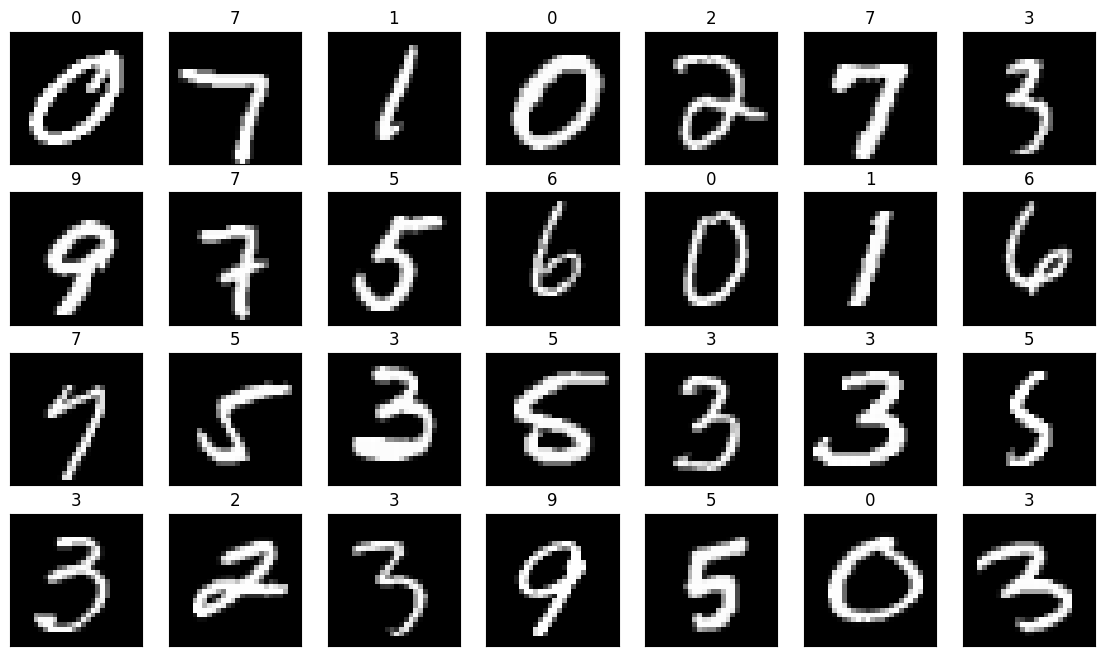

In [3]:
def show_random_grid(X: np.ndarray, y: np.ndarray, grid_dim: tuple[int, int], vector_input: bool) -> None:
    # Sample images are selected from the first.
    images = np.copy(X)
    labels = np.copy(y)

    if vector_input:
        images = images.reshape(-1, 28, 28, 1)

    # 25 Sample images will appear in a square grid.
    rows, columns = grid_dim
    # List with 25 random image indices.
    image_indices = random.sample(range(len(images)), rows * columns)
    # Their corresponding data. 
    images = [images[i] for i in image_indices]
    # Their corresponding labels. 
    labels = [labels[i] for i in image_indices]

    # Define figure
    fig=plt.figure(figsize=(2 * columns, 2 * rows))
    # Visualize these random images
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title("{}".format(labels[i-1]))
    plt.show()

show_random_grid(X_train, labels_train, grid_dim=(4, 7), vector_input=False)

(elapsed: 0.6s)

Autoencoders perform **semi-supervised learning**, meaning that the samples themselves are the target values.  
In order to complete the project's task, the sample training set $X$ and the target training set $Y$ should have the following form:
$$
    X: N \times 28 \times 28 \Rightarrow Y: N \times 28 \times 28
$$
$$
    x \in X \Leftrightarrow x \in Y
$$
$$
    X_i \in C_k \Leftrightarrow Y_i \in C_{(k+1)\: mod\: 10}
$$
where $C_0, C_1, ..., C_9$ the 10 classes of the MNIST dataset.  

To achieve this, the training set, `X_train`, should be sorted by class.

In [4]:
# Lists with the subsets of samples of the same class
X_train_classwise = [None for _ in range(10)]
Y_train_classwise = [None for _ in range(10)]

for class_id in range(10):
   # Take the indices of the samples whose labels are the same
   class_indices = np.where(labels_train == class_id)
   # Assign the subset of those samples to the next position of the list
   X_train_classwise[class_id] = X_train[class_indices]

for class_id in range(10):
   # Take the indices of the samples of the next class
   target_indices = np.where(labels_train == ((class_id + 1) % 10))
   # Assign the samples of the (i+1)-th class to the i-th position
   Y_train_classwise[class_id] = X_train[target_indices]

(elapsed: 0.1s)

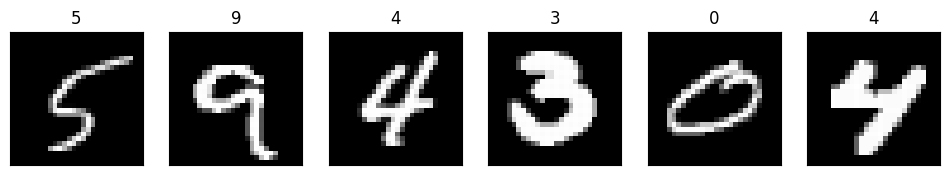

In [5]:
# Normalize and Unify the data
X_train_normal = np.concatenate(tuple([X_train_classwise[i] / 255. for i in range(10)]), axis=0, dtype=np.float32)
Y_train_normal = np.concatenate(tuple([Y_train_classwise[i] / 255. for i in range(10)]), axis=0, dtype=np.float32)
# Shuffle the indices
indices = [i for i in range(N_TRAIN)]
random.shuffle(indices)
# Shuffle the data
X_train_normal = X_train_normal[indices]
Y_train_normal = Y_train_normal[indices]
# Match the labels accordingly
labels_train = np.sort(labels_train)
labels_train = labels_train[indices]

# Example grid
show_random_grid(X_train_normal, labels_train, (1, 6), False)

(elapsed: 0.6s)

In [6]:
# Apply normalization to the test set as well
X_test_normal = np.divide(X_test, 255., dtype=np.float32)

(elapsed: 0.0s)

### Input and Output plotting
The following python cell implements the function `show_random_xy_pairs`, which shows $n$ input samples in the first row and their $n$ corresponding output samples (expected/prediction) in the second row.

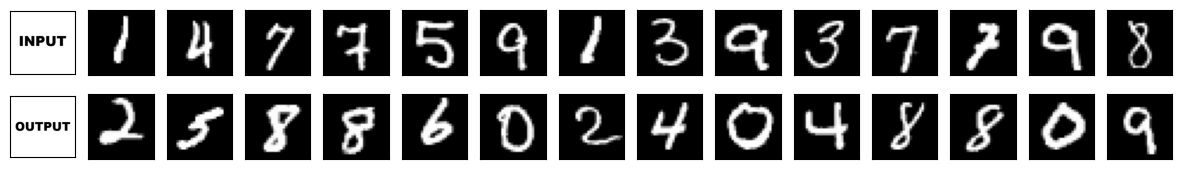

In [7]:
from PIL import Image

def show_random_xy_pairs(X: np.ndarray, Y: np.ndarray, num_samples: int):
    # Sample images are selected.
    image_indices = random.sample(range(X.shape[0]), num_samples)

    input_text = np.array(Image.open('./utils/input.PNG').convert('L'))
    output_text = np.array(Image.open('./utils/output.PNG').convert('L'))

    # Define figure
    fig=plt.figure(figsize=(num_samples+1, 2))
    fig.add_subplot(2, num_samples+1, 1)
    plt.imshow(input_text, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    fig.add_subplot(2, num_samples+1, num_samples+2)
    plt.imshow(output_text, cmap='gray')
    plt.xticks([])
    plt.yticks([])

    # Visualize these random images
    for i in range(1, num_samples+1):
        fig.add_subplot(2, num_samples+1, i+1)
        plt.imshow(X[image_indices[i-1]], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    for i in range(1, num_samples+1):
        fig.add_subplot(2, num_samples+1, num_samples+1+i+1)
        plt.imshow(Y[image_indices[i-1]], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

show_random_xy_pairs(X_train_normal, Y_train_normal, num_samples=14)

(elapsed: 0.7s)

It's apparent from the produced figure that each input sample corresponds to another sample of the other class.  
Thus the input and expected output datasets were formulated correctly.

### 1st Attempt
The first model is a **Multilayer Perceptron Autoencoding Network**, implemented using `keras.Sequential`.
* **Input:** normalized image of dimensions 28x28x1, i.e: $I \in \mathcal{X} = [0, 1]^{784}$
* **Encoder:** Compresses gradually the dimensions $(784 \rightarrow 128 \rightarrow 64 \rightarrow 32 \rightarrow 8)$
* **Latent Space (Bottleneck):** $\Phi = [0, 1]^{8}$
* **Decoder:** Augments gradually the dimensions $(8 \rightarrow 32 \rightarrow 64 \rightarrow 128 \rightarrow 784)$
* **Loss:** Mean Squared Error: $\mathcal{L}_n(\vec{x}, \vec{x}') \mid _{n=784} \;=\; \frac{1}{n}(\vec{x} - \vec{x}')^2$, punishes each wrongly colored pixel in output.
* **Accuracy:** Not Applicable

In [8]:
from keras import Sequential
from keras import layers


autoencoder_mlp = Sequential([
    # Input
    layers.InputLayer(input_shape=(28, 28, 1), dtype=np.float32), 
    layers.Flatten(), 

    # Encoder
    layers.Dense(128, activation='relu'), 
    layers.Dense(64, activation='tanh'),  
    layers.Dense(32, activation='tanh'), 

    # Latent Space
    layers.Dense(8, activation='tanh'), 

    # Decoder
    layers.Dense(32, activation='tanh'),  
    layers.Dense(64, activation='tanh'),  
    layers.Dense(128, activation='relu'),

    # Output
    layers.Dense(28*28, activation='sigmoid'), 
    layers.Reshape((28, 28, 1))
])
autoencoder_mlp.compile(optimizer='adam', loss='mse')

(elapsed: 0.1s)

In [212]:
# MLP-Autoencoder training
autoencoder_mlp.fit(X_train_normal, Y_train_normal, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0631
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0559
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0554
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0551
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0550


(elapsed: 22.7s)

313/313 [==============================] - 0s 1ms/step


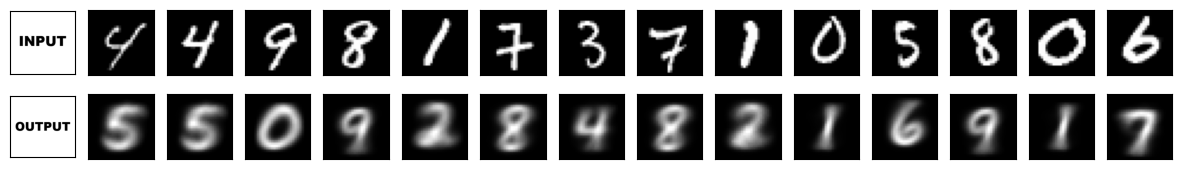

In [173]:
# Results
show_random_xy_pairs(X_test_normal, autoencoder_mlp.predict(X_test_normal), num_samples=14)

(elapsed: 1.1s)

### ScreenInput class
A `ScreenInput` object, implemented in `UserInterface.py` can be used to fetch input from the user
* **Left click:** Draw
* **Right click:** Erase canvas  
* **Close window:** Screenshot the last frame and return it to the program, continuing execution

1/1 [==============================] - 0s 21ms/step


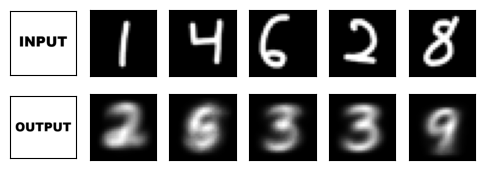

In [16]:
from UserInterface import ScreenInput

def show_user_samples(n_samples: int, model: Sequential):
    user_images = np.zeros((n_samples, 28, 28, 1), dtype=np.float32)
    for i in range(n_samples):
        print(f'Current: {i+1}/{n_samples}\r', end='')
        # Get handwritten image from a 320x300 window
        user_image = ScreenInput(width=320, height=300, out_dim=(28, 28)).display().get_drawn_image()
        user_image = user_image.reshape((28, 28, 1)) / 255.
        # Store each image in the following np.ndarray
        user_images[i] = user_image
    
    # The Autoencoder predicts (draws) the following digit of each input
    input_predictions = model.predict(user_images)
    show_random_xy_pairs(user_images, input_predictions, n_samples)

# Fetch 5 handrawn samples from the screen
show_user_samples(n_samples=5, model=autoencoder_mlp)

### Observations
The produced images, while mostly guessed right, seem to be very blurry. This could be a result from the fact that the Autoencoder produces the "median" digit.  
An idea to prevent this would be to use a prototype digit for each class to have a more stable output.  
I.e: all zeros are trained with the same ace, all fours are trained with the same five etc.  

For this purpose, 10 prototype digits were created in a **Paint application** and are stored in the `./utils/prototypes/` directory.  
Thus, the previous conditions can be rephrased as:
$$
    X: N \times 28 \times 28 \Rightarrow Y: N \times 28 \times 28
$$
$$
    \vec{d}: 10 \times1,\; d_i \in C_i
$$
$$
    X_i \in C_k \Leftrightarrow Y_i = d_{(k+1)\:mod\:10}
$$

In [213]:
from PIL import Image

prototype_digits = [Image.open('./utils/prototypes/{}.PNG'.format(n)).resize((28, 28)).convert('L') for n in range(10)]

X_train = np.concatenate(tuple([class_samples for class_samples in X_train_classwise]), axis=0)
labels_train = np.sort(labels_train)

# Set Y[i] = d[(i+1) % 10]
Y_train = np.zeros(X_train.shape)
for i in range(N_TRAIN):
    Y_train[i] = np.array(prototype_digits[(labels_train[i] + 1) % 10]).reshape(28, 28, 1)

print(Y_train.shape)

# Shuffle dataset
indices = [i for i in range(N_TRAIN)]
random.shuffle(indices)
X_train = X_train[indices]
Y_train = Y_train[indices]
labels_train = labels_train[indices]

# Normalize
X_train_normal = X_train / 255.
Y_train_normal = Y_train / 255.
X_test_normal = X_test / 255.

(60000, 28, 28, 1)


In [214]:
# Append the prototype digits to the dataset
prototype_digits_array = np.zeros(shape=(10, 28, 28, 1), dtype=np.float32)
prototype_digits_next = np.zeros(shape=(10, 28, 28, 1), dtype=np.float32)

for i in range(10):
    prototype_digits_array[i] = np.array(prototype_digits[i], dtype=np.float32).reshape(28, 28, 1) / 255.
    prototype_digits_next[i] = np.array(prototype_digits[(i + 1) % 10], dtype=np.float32).reshape(28, 28, 1) / 255.

X_train_normal = np.concatenate((X_train_normal, prototype_digits_array), axis=0, dtype=np.float32)
Y_train_normal = np.concatenate((Y_train_normal, prototype_digits_next), axis=0, dtype=np.float32)
labels_train = np.concatenate((labels_train, np.array([i for i in range(10)], dtype=np.uint8)), dtype=np.uint8)

(elapsed: 1.3s)

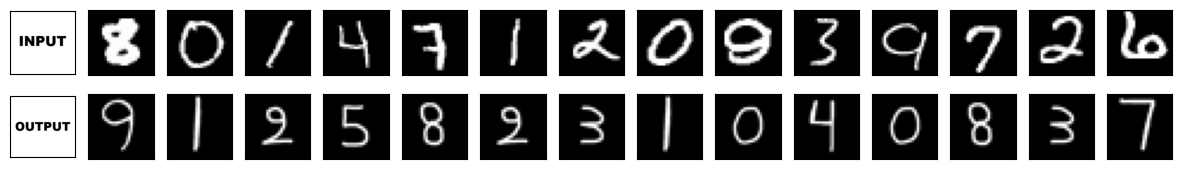

In [215]:
show_random_xy_pairs(X_train_normal, Y_train_normal, 14)

(elapsed: 0.7s)

In [216]:
from keras import Sequential
from keras import layers

autoencoder_mlp = Sequential([
    # Input
    layers.InputLayer(input_shape=(28, 28, 1), dtype=np.float32), 
    layers.Flatten(), 

    # Encoder
    layers.Dense(128, activation='relu'), 
    layers.Dense(64, activation='tanh'),  
    layers.Dense(32, activation='tanh'), 

    # Latent Space
    layers.Dense(8, activation='tanh'), 

    # Decoder
    layers.Dense(32, activation='tanh'),  
    layers.Dense(64, activation='tanh'),  
    layers.Dense(128, activation='relu'),

    # Output
    layers.Dense(28*28, activation='sigmoid'), 
    layers.Reshape((28, 28, 1))
])
autoencoder_mlp.compile(optimizer='adam', loss='mse')

(elapsed: 0.1s)

In [217]:
autoencoder_mlp.fit(X_train_normal, Y_train_normal, epochs=5)

Epoch 1/5
1876/1876 [==============================] - 5s 2ms/step - loss: 0.0194
Epoch 2/5
1876/1876 [==============================] - 4s 2ms/step - loss: 0.0029
Epoch 3/5
1876/1876 [==============================] - 4s 2ms/step - loss: 0.0022
Epoch 4/5
1876/1876 [==============================] - 4s 2ms/step - loss: 0.0018
Epoch 5/5
1876/1876 [==============================] - 5s 2ms/step - loss: 0.0015


(elapsed: 21.9s)

313/313 [==============================] - 0s 1ms/step


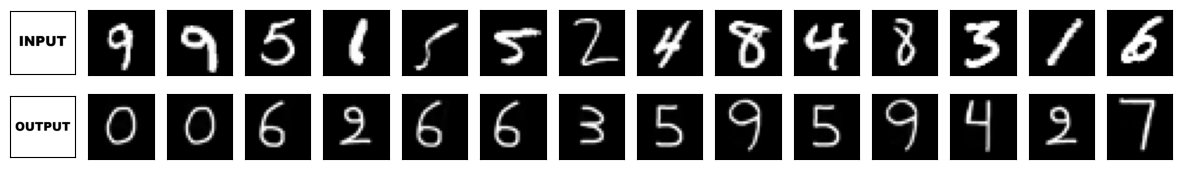

In [218]:
show_random_xy_pairs(X_test_normal, autoencoder_mlp.predict(X_test_normal), 14)

(elapsed: 1.1s)

1/1 [==============================] - 0s 19ms/step


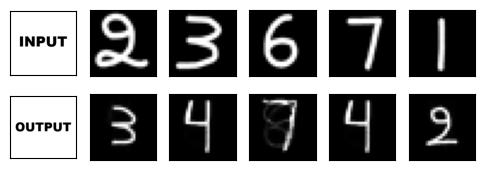

In [200]:
show_user_samples(n_samples=5, model=autoencoder_mlp)

The results seem better as they are not blurry but some of the samples may not produce the following one.  
This happens mostly with digits inserted through the use of `UserInterface.ScreenInput`.  
Perhaps ~100% accuracy could be achieved as well if the Autoencoder used convolution.

### 2nd Attempt

The second model is a **Convolutional Autoencoding Network**, both during encoding and decoding.
* **Input:** normalized image of dimensions 28x28x1, i.e: $I \in \mathcal{X} = \mathcal{T}^{[0, 1]}_{28,\, 28,\, 1}$
* **Encoder:** Compresses gradually the dimensions by convolving and pooling.
* **Latent Space (Bottleneck):** $\Phi = \mathcal{T}^{[0, 1]}_{4,\, 4,\, 8}$
* **Decoder:** Augments gradually the dimensions by convolving and upsampling.
* **Loss:** Mean Squared Error: $\mathcal{L}_N(\vec{x}, \vec{x}') \mid _{N=784} \;=\; \frac{1}{N}(\vec{x} - \vec{x}')^2$, punishes each wrongly colored pixel in output.
* **Accuracy:** Not Applicable

In [219]:
from keras import Sequential
from keras import layers


autoencoder_conv = Sequential([
    # Input
    layers.InputLayer(input_shape=(28, 28, 1)), 

    # Encoder
    layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    layers.MaxPool2D((2, 2), padding='same'),
    layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    layers.MaxPool2D((2, 2), padding='same'),
    layers.Conv2D(16, (3, 3), activation='sigmoid', padding='same'),
    layers.MaxPool2D((2, 2), padding='same'),

    # Latent Space...

    # Decoder
    layers.Conv2D(16, (3, 3), activation='sigmoid', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='sigmoid'),
    layers.UpSampling2D((2, 2)),

    # Output
    layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')
])
autoencoder_conv.compile(optimizer='adam', loss='mse')

(elapsed: 0.1s)

In [220]:
autoencoder_conv.fit(X_train_normal, Y_train_normal, epochs=10)

Epoch 1/10
1876/1876 [==============================] - 97s 51ms/step - loss: 0.0371
Epoch 2/10
1876/1876 [==============================] - 96s 51ms/step - loss: 0.0239
Epoch 3/10
1876/1876 [==============================] - 95s 50ms/step - loss: 0.0169
Epoch 4/10
1876/1876 [==============================] - 88s 47ms/step - loss: 0.0124
Epoch 5/10
1876/1876 [==============================] - 88s 47ms/step - loss: 0.0095
Epoch 6/10
1876/1876 [==============================] - 92s 49ms/step - loss: 0.0074
Epoch 7/10
1876/1876 [==============================] - 98s 52ms/step - loss: 0.0059
Epoch 8/10
1876/1876 [==============================] - 97s 52ms/step - loss: 0.0050
Epoch 9/10
1876/1876 [==============================] - 98s 52ms/step - loss: 0.0043
Epoch 10/10
1876/1876 [==============================] - 98s 52ms/step - loss: 0.0037


(elapsed: 15m, 46.2s)

313/313 [==============================] - 3s 11ms/step


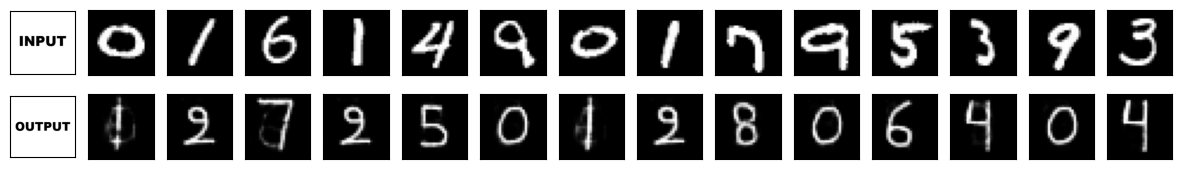

In [221]:
show_random_xy_pairs(X_test_normal, autoencoder_conv.predict(X_test_normal), 14)

(elapsed: 2.9s)

1/1 [==============================] - 0s 24ms/step


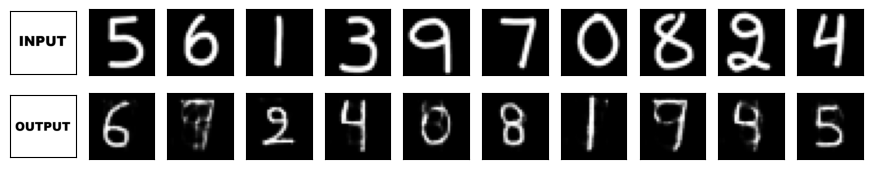

In [225]:
show_user_samples(n_samples=10, model=autoencoder_conv)

The model above shows very good performance but its training takes too long.  
Perhaps a mixed model could be implemented, such that the encoder is convolutional and the decoder is MLP.  
This would make the encoder powerful at correctly analyzing the input, as it will be favored from all the properties of convolution.  
At the same time, the output is a specific prototype digit which an MLP could handle easily and way faster.

### 3rd Attempt
The last autoencoder will utilise both convolution and perceptron.  
The enocder will have convolutional architecture while the Decoder will have an MLP architecture.  
This way the encoder will correctly capture the features of the input images, being favored from all the properties of convolution.  
Meanwhile the Decoder will accurately train to generate the output prototype images from the compressed data.

In [227]:
autoencoder_mixed = Sequential([
    # Input
    layers.InputLayer(input_shape=(28, 28, 1)), 

    # Encoder 
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'), 
    layers.MaxPool2D((2, 2), padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'), 
    layers.MaxPool2D((2, 2), padding='same'),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'), 
    layers.MaxPool2D((2, 2), padding='same'),

    # Latent Space...

    # Decoder 
    layers.Dense(16, activation='sigmoid'), 
    layers.Dense(32, activation='sigmoid'), 
    layers.Dense(64, activation='sigmoid'), 
    layers.Flatten(), 

    # Output
    layers.Dense(28*28, activation='sigmoid'), 
    layers.Reshape((28, 28, 1))
])
autoencoder_mixed.compile(optimizer='adam', loss='mse')
autoencoder_mixed.summary()

In [228]:
autoencoder_mixed.fit(X_train_normal, Y_train_normal, epochs=10)

Epoch 1/10
1876/1876 [==============================] - 45s 24ms/step - loss: 0.0152
Epoch 2/10
1876/1876 [==============================] - 44s 23ms/step - loss: 0.0045
Epoch 3/10
1876/1876 [==============================] - 45s 24ms/step - loss: 0.0034
Epoch 4/10
1876/1876 [==============================] - 45s 24ms/step - loss: 0.0029
Epoch 5/10
1876/1876 [==============================] - 44s 24ms/step - loss: 0.0025
Epoch 6/10
1876/1876 [==============================] - 44s 24ms/step - loss: 0.0023
Epoch 7/10
1876/1876 [==============================] - 44s 24ms/step - loss: 0.0021
Epoch 8/10
1876/1876 [==============================] - 44s 24ms/step - loss: 0.0019
Epoch 9/10
1876/1876 [==============================] - 44s 24ms/step - loss: 0.0018
Epoch 10/10
1876/1876 [==============================] - 44s 24ms/step - loss: 0.0017


(elapsed: 7m, 17.8s)

313/313 [==============================] - 2s 5ms/step


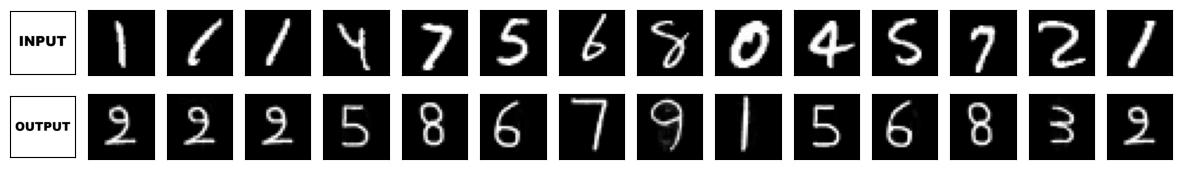

In [290]:
show_random_xy_pairs(X_test_normal, autoencoder_mixed.predict(X_test_normal), 14)

(elapsed: 3.3s)

1/1 [==============================] - 0s 30ms/step


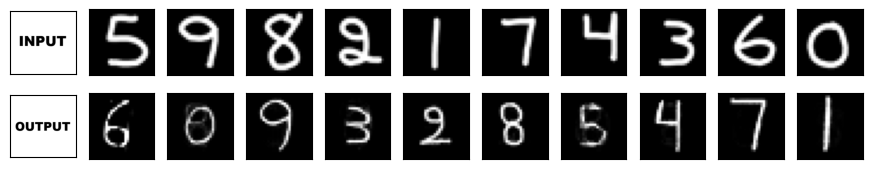

In [231]:
show_user_samples(n_samples=10, model=autoencoder_mixed)

### Next Phase
Previously, the accuracy of the reconstructed digits were validated visually through the `show_random_xy_pairs(...)` and `show_user_samples()` functions.  
Now the quality of the reconstructed digits will be validated through a MNIST digit classifier.  

More specifically, a neural network will be trained to classify digits.  
A simple `keras.Sequential` with dense layers is suitable for this as it can achieve almost perfect accuracy.  

Each one of the 3 previous models will be evaluated based on the classification accuracy of its output.  
For each output digit $x'$ that is reconstructed from $x \in C_k$, the autoencoder succeeds only if the classifier predicts its label as $C_{(k+1)\: mod\: 10}$

In [281]:
classifier = Sequential([
    layers.InputLayer(input_shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'), 
    layers.Dense(128, activation='relu'), 
    layers.Dense(64, activation='sigmoid'), 
    layers.Dense(32, activation='sigmoid'), 
    layers.Dense(10, activation='softmax')
])
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [282]:
# One-hot encode the output labels
from keras.utils import to_categorical
labels_train_encoded = to_categorical(labels_train, 10)
labels_test_encoded = to_categorical(labels_test, 10)

In [283]:
classifier.fit(X_train_normal, labels_train_encoded, epochs=5)

Epoch 1/5
1876/1876 [==============================] - 5s 2ms/step - loss: 0.3962 - accuracy: 0.9174
Epoch 2/5
1876/1876 [==============================] - 4s 2ms/step - loss: 0.1071 - accuracy: 0.9703
Epoch 3/5
1876/1876 [==============================] - 4s 2ms/step - loss: 0.0712 - accuracy: 0.9796
Epoch 4/5
1876/1876 [==============================] - 4s 2ms/step - loss: 0.0543 - accuracy: 0.9843
Epoch 5/5
1876/1876 [==============================] - 4s 2ms/step - loss: 0.0432 - accuracy: 0.9875


(elapsed: 22.5s)

In [284]:
classifier.evaluate(X_test_normal, labels_test_encoded)

313/313 [==============================] - 1s 1ms/step - loss: 0.0823 - accuracy: 0.9776


[0.08228974789381027, 0.9775999784469604]

The classifier has ~98% accuracy making it worthy enough to evaluate the 3 autoencoders.

In [288]:
model_names = {
    autoencoder_mlp : 'MLP Autoencoder', 
    autoencoder_conv : 'Convolutional Autoencoder', 
    autoencoder_mixed : 'Hybrid Autoencoder'
}

for model in (autoencoder_mlp, autoencoder_conv, autoencoder_mixed):
    # Each autoencoder predicts the next digits for all the test samples 
    autoencoder_output = model.predict(X_test_normal, verbose=0)
    # The classifier decides the class of the output images
    predictions = np.array([np.argmax(pred) for pred in classifier.predict(autoencoder_output, verbose=0)])
    # The classifier evaluates each autoencoder's accuracy, meaning that it 
    # tests to see if the produced output mathches the expected output label
    correctly_classified = np.where(predictions == labels_test + 1)[0]
    accuracy = correctly_classified.shape[0] / predictions.shape[0]
    print(f"{model_names[model]} accuracy: {100 * accuracy}%")

MLP Autoencoder accuracy: 77.62%
Convolutional Autoencoder accuracy: 74.63%
Hybrid Autoencoder accuracy: 76.25%


### Conlusion & Commentary
It is apparent from the results of this project that Autoencoders have several strengths that should be noted:
* They can create a powerful **latent space** for their samples, performing great compression with minimal information loss.  
* Apart from denoising tasks, for which they were traditionally created for, they can also perform generative tasks.  
    This was proven in the context of this project as the input images and the reconstructed images belonged to different classes.  

The task of this project, while making an atypical utilisation of autoencoders, produces interesting results as it goes to show the  
autoencoder's potency to perform data filtering as well as prediciting modeling.